### 利用TensorFlow2.0建立时间序列RNN模型，对国内的新冠肺炎疫情结束时间进行预测

1. 数据准备
   - 数据集取自tushare

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow.keras import models,layers,losses,metrics,callbacks 

2023-08-18 11:25:50.192347: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-18 11:25:50.252732: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-18 11:25:50.253911: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-18 11:25:51.426540: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.]),
 [Text(-10.0, 0, '2020-03-01'),
  Text(0.0, 0, '2020-01-24'),
  Text(10.0, 0, '2020-02-03'),
  Text(20.0, 0, '2020-02-13'),
  Text(30.0, 0, '2020-02-23'),
  Text(40.0, 0, '2020-03-04'),
  Text(50.0, 0, '')])

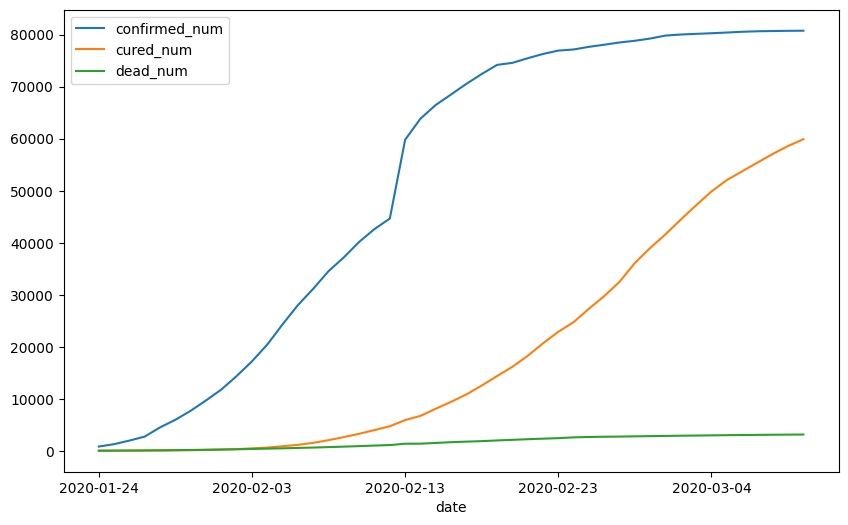

In [2]:
df = pd.read_csv("../data/covid-19.csv",sep = "\t")
df.plot(x = "date",y = ["confirmed_num","cured_num","dead_num"],figsize=(10,6))
plt.xticks(rotation=0)

In [3]:
dfdata = df.set_index("date")
dfdata 

,confirmed_num,cured_num,dead_num
date,,,
2020-01-24,830.0,34.0,25.0
2020-01-25,1287.0,38.0,41.0
2020-01-26,1975.0,49.0,56.0
2020-01-27,2744.0,51.0,80.0
2020-01-28,4515.0,60.0,106.0
2020-01-29,5974.0,103.0,132.0
2020-01-30,7711.0,124.0,170.0
2020-01-31,9692.0,171.0,213.0
2020-02-01,11791.0,259.0,243.0


In [4]:
dfdiff = dfdata.diff(periods=1).dropna()
dfdiff

,confirmed_num,cured_num,dead_num
date,,,
2020-01-25,457.0,4.0,16.0
2020-01-26,688.0,11.0,15.0
2020-01-27,769.0,2.0,24.0
2020-01-28,1771.0,9.0,26.0
2020-01-29,1459.0,43.0,26.0
2020-01-30,1737.0,21.0,38.0
2020-01-31,1981.0,47.0,43.0
2020-02-01,2099.0,88.0,30.0
2020-02-02,2589.0,69.0,61.0


In [5]:
dfdiff = dfdiff.reset_index("date")
dfdiff

,date,confirmed_num,cured_num,dead_num
0,2020-01-25,457.0,4.0,16.0
1,2020-01-26,688.0,11.0,15.0
2,2020-01-27,769.0,2.0,24.0
3,2020-01-28,1771.0,9.0,26.0
4,2020-01-29,1459.0,43.0,26.0
5,2020-01-30,1737.0,21.0,38.0
6,2020-01-31,1981.0,47.0,43.0
7,2020-02-01,2099.0,88.0,30.0
8,2020-02-02,2589.0,69.0,61.0
9,2020-02-03,2825.0,147.0,57.0


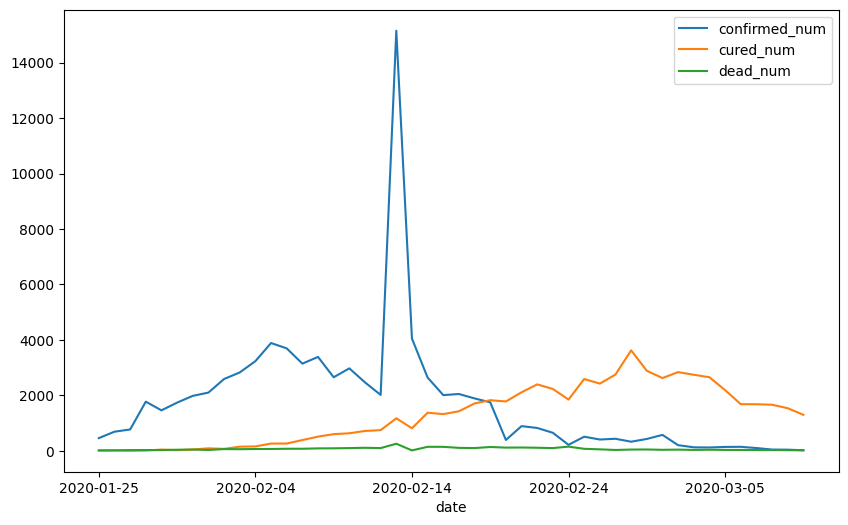

In [6]:
dfdiff.plot(x = "date",y = ["confirmed_num","cured_num","dead_num"],figsize=(10,6))
plt.xticks(rotation=0)
dfdiff = dfdiff.drop("date",axis = 1).astype("float32")

In [7]:
#用某日前8天窗口数据作为输入预测该日数据
WINDOW_SIZE = 8

def batch_dataset(dataset):
    dataset_batched = dataset.batch(WINDOW_SIZE,drop_remainder=True)
    return dataset_batched

ds_data = tf.data.Dataset.from_tensor_slices(tf.constant(dfdiff.values,dtype = tf.float32)) \
   .window(WINDOW_SIZE,shift=1).flat_map(batch_dataset)

ds_label = tf.data.Dataset.from_tensor_slices(
    tf.constant(dfdiff.values[WINDOW_SIZE:],dtype = tf.float32))

#数据较小，可以将全部训练数据放入到一个batch中，提升性能
ds_train = tf.data.Dataset.zip((ds_data,ds_label)).batch(38).cache()

2023-08-18 11:26:15.078665: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-18 11:26:15.123648: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


2. 定义模型

In [8]:
# 使用函数式API构建任意结构模型
#考虑到新增确诊，新增治愈，新增死亡人数数据不可能小于0，设计如下结构
class Block(layers.Layer):
    def __init__(self, **kwargs):
        super(Block, self).__init__(**kwargs)

    def call(self, x_input,x):
        x_out = tf.maximum((1+x)*x_input[:,-1,:],0.0)
        return x_out

    def get_config(self):  
        config = super(Block, self).get_config()
        return config

In [9]:
tf.keras.backend.clear_session()
x_input = layers.Input(shape = (None,3),dtype = tf.float32)
x = layers.LSTM(3,return_sequences = True,input_shape=(None,3))(x_input)
x = layers.LSTM(3,return_sequences = True,input_shape=(None,3))(x)
x = layers.LSTM(3,return_sequences = True,input_shape=(None,3))(x)
x = layers.LSTM(3,input_shape=(None,3))(x)
x = layers.Dense(3)(x)

#考虑到新增确诊，新增治愈，新增死亡人数数据不可能小于0，设计如下结构
#x = tf.maximum((1+x)*x_input[:,-1,:],0.0)
x = Block()(x_input,x)
model = models.Model(inputs = [x_input],outputs = [x])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, 3)]            0         []                            
                                                                                                  
 lstm (LSTM)                 (None, None, 3)              84        ['input_1[0][0]']             
                                                                                                  
 lstm_1 (LSTM)               (None, None, 3)              84        ['lstm[0][0]']                
                                                                                                  
 lstm_2 (LSTM)               (None, None, 3)              84        ['lstm_1[0][0]']              
                                                                                              

3. 训练模型

In [10]:
#自定义损失函数，考虑平方差和预测目标的比值
class MSPE(losses.Loss):
    def call(self,y_true,y_pred):
        err_percent = (y_true - y_pred)**2/(tf.maximum(y_true**2,1e-7))
        mean_err_percent = tf.reduce_mean(err_percent)
        return mean_err_percent

    def get_config(self):
        config = super(MSPE, self).get_config()
        return config

In [11]:
import os
import datetime

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=optimizer,loss=MSPE(name = "MSPE"))

stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = os.path.join('data', 'autograph', stamp)

## 在 Python3 下建议使用 pathlib 修正各操作系统的路径
# from pathlib import Path
# stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# logdir = str(Path('../../data/autograph/' + stamp))

tb_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
#如果loss在100个epoch后没有提升，学习率减半。
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor="loss",factor = 0.5, patience = 100)
#当loss在200个epoch后没有提升，则提前终止训练。
stop_callback = tf.keras.callbacks.EarlyStopping(monitor = "loss", patience= 200)
callbacks_list = [tb_callback,lr_callback,stop_callback]

history = model.fit(ds_train,epochs=500,callbacks = callbacks_list)

Epoch 1/500
1/1 [==============================] - 9s 9s/step - loss: 3.8299 - lr: 0.0100
Epoch 2/500
1/1 [==============================] - 0s 146ms/step - loss: 3.4548 - lr: 0.0100
Epoch 3/500
1/1 [==============================] - 0s 157ms/step - loss: 3.1547 - lr: 0.0100
Epoch 4/500
1/1 [==============================] - 0s 156ms/step - loss: 2.8549 - lr: 0.0100
Epoch 5/500
1/1 [==============================] - 0s 152ms/step - loss: 2.5659 - lr: 0.0100
Epoch 6/500
1/1 [==============================] - 0s 182ms/step - loss: 2.2927 - lr: 0.0100
Epoch 7/500
1/1 [==============================] - 0s 166ms/step - loss: 2.0378 - lr: 0.0100
Epoch 8/500
1/1 [==============================] - 0s 152ms/step - loss: 1.8021 - lr: 0.0100
Epoch 9/500
1/1 [==============================] - 0s 168ms/step - loss: 1.5872 - lr: 0.0100
Epoch 10/500
1/1 [==============================] - 0s 152ms/step - loss: 1.3947 - lr: 0.0100
Epoch 11/500
1/1 [==============================] - 0s 153ms/step - loss

4. 评估模型

In [12]:
import matplotlib.pyplot as plt

def plot_metric(history, metric):
    train_metrics = history.history[metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.title('Training '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric])
    plt.show()

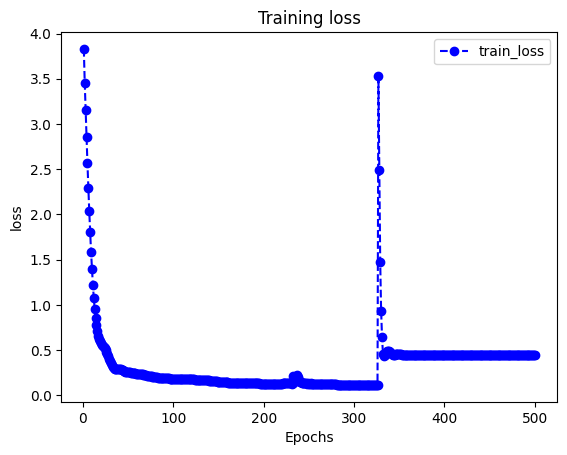

In [13]:
plot_metric(history,"loss")

5. 使用模型预测

In [14]:
#使用dfresult记录现有数据以及此后预测的疫情数据
dfresult = dfdiff[["confirmed_num","cured_num","dead_num"]].copy()
dfresult.tail()

,confirmed_num,cured_num,dead_num
41,143.0,1681.0,30.0
42,99.0,1678.0,28.0
43,44.0,1661.0,27.0
44,40.0,1535.0,22.0
45,19.0,1297.0,17.0


In [19]:
#预测此后100天的新增走势,将其结果添加到dfresult中
for i in range(500):
    arr_predict = model.predict(tf.constant(tf.expand_dims(dfresult.values[-38:,:],axis = 0)))

    dfpredict = pd.DataFrame(tf.cast(tf.floor(arr_predict),tf.float32).numpy(),
                columns = dfresult.columns)
    # dfresult = dfresult.append(dfpredict,ignore_index=True)
    dfresult = pd.concat([dfpredict,dfresult],ignore_index=True)

1/1 [==============================] - 0s 30ms/step


In [24]:
dfresult.query("confirmed_num<15").head()

,confirmed_num,cured_num,dead_num
0,10.0,1304.0,0.0
1,10.0,1304.0,0.0
2,10.0,1304.0,0.0
3,10.0,1304.0,0.0
4,10.0,1304.0,0.0


In [26]:
dfresult.query("cured_num>0").head()

# 第164天开始新增治愈降为0，第45天对应3月10日，也就是大概4个月后，即7月10日左右全部治愈。
# 注: 该预测偏悲观，并且存在问题，如果将每天新增治愈人数加起来，将超过累计确诊人数。

,confirmed_num,cured_num,dead_num
0,10.0,1304.0,0.0
1,10.0,1304.0,0.0
2,10.0,1304.0,0.0
3,10.0,1304.0,0.0
4,10.0,1304.0,0.0


In [27]:
dfresult.query("dead_num==0").head()

# 第60天开始，新增死亡降为0，第45天对应3月10日，也就是大概15天后，即20200325
# 该预测较为合理

,confirmed_num,cured_num,dead_num
0,10.0,1304.0,0.0
1,10.0,1304.0,0.0
2,10.0,1304.0,0.0
3,10.0,1304.0,0.0
4,10.0,1304.0,0.0


6. 保存模型

In [28]:
model.save('../data/tf_model_savedmodel', save_format="tf")
print('export saved model.')

INFO:tensorflow:Assets written to: ../data/tf_model_savedmodel/assets


INFO:tensorflow:Assets written to: ../data/tf_model_savedmodel/assets


export saved model.


In [29]:
model_loaded = tf.keras.models.load_model('../data/tf_model_savedmodel',compile=False)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model_loaded.compile(optimizer=optimizer,loss=MSPE(name = "MSPE"))
model_loaded.predict(ds_train)

2/2 [==============================] - 2s 21ms/step


array([[1083.2078  ,   87.21216 ,    0.      ],
       [1336.0767  ,   68.38226 ,    0.      ],
       [1457.8666  ,  145.68394 ,    0.      ],
       [1668.4187  ,  155.59442 ,    0.      ],
       [2005.4052  ,  257.6723  ,    0.      ],
       [1906.3219  ,  258.66333 ,    0.      ],
       [1621.9734  ,  383.53528 ,    0.      ],
       [1746.8596  ,  505.4341  ,    0.      ],
       [1368.5884  ,  593.6373  ,    0.      ],
       [1534.2434  ,  626.34186 ,    0.      ],
       [1273.1176  ,  708.5988  ,    0.      ],
       [1039.8589  ,  737.3392  ,    0.      ],
       [7818.8096  , 1160.5164  ,    0.      ],
       [2088.4907  ,  804.7304  ,    0.      ],
       [1362.9117  , 1360.7079  ,    0.      ],
       [1038.1532  , 1311.5708  ,    0.      ],
       [1059.0576  , 1412.7567  ,    0.      ],
       [ 964.05756 , 1689.6624  ,    0.      ],
       [ 886.6579  , 1802.2158  ,    0.      ],
       [ 204.04985 , 1766.6075  ,    0.      ],
       [ 467.80548 , 2097.5476  ,    0. 